# Amazon food review dataset apply knn to predict polarity review

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews

# Objective
Here try BOW,TFIDF,avg W2V, avg TFIDFW2V and split train test 70-30 10fold cross validation and find optimal k
report test accuracy. Use brute force and kd-tree for building knn.

# Import data and libraries
 
 

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Data preprocessing

In [5]:
filtered_data=raw_data

# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.sample(2)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Get straritied sampling
from sklearn.cross_validation import train_test_split
_ , clean_data = train_test_split(sorted_data, test_size = 10000, random_state=0,stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()


# Clean html tag and punctuation
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
    
clean_data['CleanedText']=final_string
#store for future use
#conn = sqlite3.connect('clean_data.sqlite')
#c=conn.cursor()
#conn.text_factory = str
#clean_data.to_sql('Reviews1', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
#con = sqlite3.connect('clean_data.sqlite') 
#clean_data = pd.read_sql_query("""SELECT * FROM Reviews1 WHERE Score != 3""", con) 
print(clean_data.shape)

#Sort data on timestamp descending
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
clean_data.sample(2)    

(10000, 11)


C:\Users\suman\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
309932,335613,B004B4368O,AXG1FSS19B9QL,chai lover,0,0,positive,1292025600,Delicious Chai,I have tried so many different brands of Chai ...,b'tri mani differ brand chai far favorit easi ...
188229,204159,B0009F3QKW,AX75O9MUM3MAH,daisey,0,1,negative,1294444800,A little too sweet...,This tea would be nice if wasn't so sweet. Th...,b'tea would nice wasnt sweet cinnamon tast gre...


# Split train and test

In [7]:
x=clean_data['CleanedText'].values
y = clean_data['Score']
#time=time.reset_index(drop=True)
n=x.shape[0]
n1=int(n*.3)
X_test_raw = x[0:n1]
X_train_raw= x[n1:n+1]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train_raw.shape, X_test_raw.shape,y_train.shape,y_test.shape)
print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

size of X_train, X_test, y_train , y_test  (7000,) (3000,) (7000,) (3000,)
positive and negative review in train and test
 positive    5939
negative    1061
Name: Score, dtype: int64 
 positive    2493
negative     507
Name: Score, dtype: int64


# Model using BOW knn

In [8]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train_raw)

#use the same vectors to convert test data
X_test=count_vect.transform(X_test_raw)
print(X_train.get_shape(),X_test.get_shape())
#print(final_counts[[1]])
#print(final_counts[0,:])# this is stored like dict format only non zero values. sparse matrix
#x = pd.DataFrame(final_counts.toarray())#this is stored like dataframe format all 0 and non zero values. dense matrix
# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])

(7000, 11134) (3000, 11134)


In [9]:
#x=final_counts
#y = clean_data['Score']
#n=x.shape[0]
#n1=int(n*.3)
#X_test = x[0:n1,:]
#X_train= x[n1:n+1,:]
#y_test=y[0:n1]
#y_train=y[n1:n+1]
#print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
#print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

In [10]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

In [11]:
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
  
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using brute is',optimal_k,MSE.index(min(MSE)))


The optimal number of neighbors and misclassification error using brute is 9 4


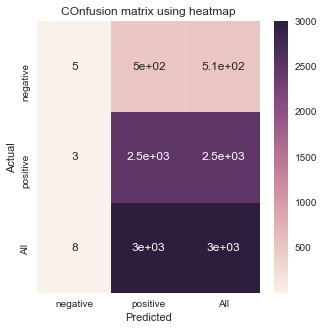

In [12]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

pred = knn_optimal.predict(X_train)
acc1 = accuracy_score(y_train, pred) * 100
pred = knn_optimal.predict(X_test)
acc = accuracy_score(y_test, pred) * 100

aa=pd.DataFrame({'type':['BOW brute'],'train_score':[acc1],'test_score':[acc],'K':[optimal_k]})
#confusion matrix using heatmap seaboarn
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
plt.figure(figsize=(5,5))
sns.heatmap(mat,annot=True)
plt.title("COnfusion matrix using heatmap")
plt.show()


The optimal number of neighbors and misclassification error using kd-tree is 9 4
Predicted  negative  positive   All
Actual                             
negative          5       502   507
positive          3      2490  2493
All               8      2992  3000


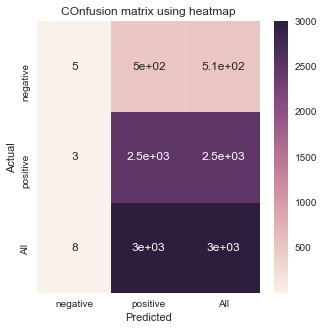

In [13]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')
    
# Use KDtree
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using kd-tree is',optimal_k,MSE.index(min(MSE)))  

# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

#print('\nThe accuracy of the knn classifier using kd-tree for k = %d is %f%%' % (optimal_k, acc)) 
pred = knn_optimal.predict(X_train)
acctrain = accuracy_score(y_train, pred) * 100
predtest = knn_optimal.predict(X_test)
acc = accuracy_score(y_test, predtest) * 100


bb=pd.DataFrame({'type':['BOW kdtree'],'train_score':[acctrain],'test_score':[acc],'K':[optimal_k]})
aa=aa.append(bb)

#create confusion matrix
mat=pd.crosstab(y_test, predtest, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);
plt.figure(figsize=(5,5))
sns.heatmap(mat,annot=True)
plt.title("COnfusion matrix using heatmap")
plt.show()

# plot accuracy with k 

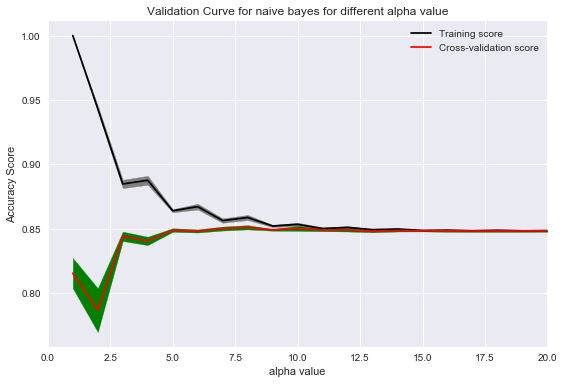

In [14]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve

#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
n_neighbors=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_range=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors",param_range=n_neighbors,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for naive bayes for different alpha value")
plt.xlabel("alpha value")
plt.ylabel("Accuracy Score")
plt.xlim(0,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Model using TFIDF


In [15]:
#now convert CleanedText to TDM
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train_raw)
#Use train vector to create vector from test
X_test=tf_idf_vect.transform(X_test_raw)

In [16]:
#x = pd.DataFrame(final_counts.toarray())
#x=final_counts
#y = clean_data['Score']
#time=time.reset_index(drop=True)
#n=x.shape[0]
#n1=int(n*.3)
#X_test = x[0:n1]
#X_train= x[n1:n+1]
#X_test = x[0:n1,:]
#X_train= x[n1:n+1,:]


#y_test=y[0:n1]
#y_train=y[n1:n+1]
#print('size of train, test, X , y ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)


In [17]:
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
  
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using kd-tree is',optimal_k,MSE.index(min(MSE)))


The optimal number of neighbors and misclassification error using kd-tree is 7 3


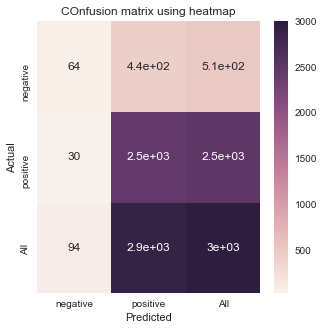

In [18]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')

# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

#print('\nThe accuracy of the knn classifier using kd-tree for k = %d is %f%%' % (optimal_k, acc))
pred = knn_optimal.predict(X_train)
acc1 = accuracy_score(y_train, pred) * 100
pred = knn_optimal.predict(X_test)
acc = accuracy_score(y_test, pred) * 100


bb=pd.DataFrame({'type':['TFIDF kd_tree'],'train_score':[acc1],'test_score':[acc],'K':[optimal_k]})
aa=aa.append(bb)
#confusion matrix using heatmap seaboarn
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
plt.figure(figsize=(5,5))
sns.heatmap(mat,annot=True)
plt.title("COnfusion matrix using heatmap")
plt.show()



The optimal number of neighbors and misclassification error using brute is 7 3
Predicted  negative  positive   All
Actual                             
negative         64       443   507
positive         30      2463  2493
All              94      2906  3000


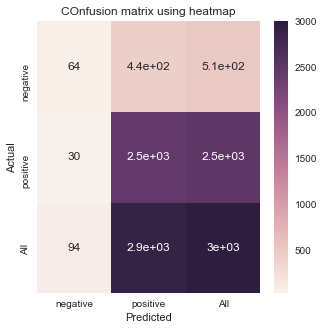

In [19]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')

# Use brute
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using brute is',optimal_k,MSE.index(min(MSE)))  

# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

pred = knn_optimal.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
#print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc)) 
pred = knn_optimal.predict(X_test)
acctrain = accuracy_score(y_test, pred) * 100

bb=pd.DataFrame({'type':['TFIDF brute'],'train_score':[acctrain],'test_score':[acc],'K':[optimal_k]})
aa=aa.append(bb)
#confusion matrix
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);
plt.figure(figsize=(5,5))
sns.heatmap(mat,annot=True)
plt.title("COnfusion matrix using heatmap")
plt.show()

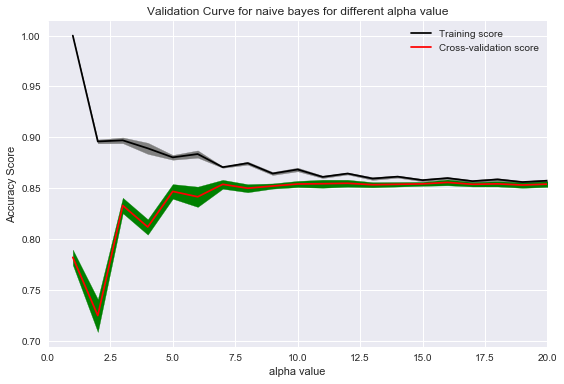

In [20]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
n_neighbors=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_range=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors",param_range=n_neighbors,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for naive bayes for different alpha value")
plt.xlabel("alpha value")
plt.ylabel("Accuracy Score")
plt.xlim(0,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Build model using avg W2V

In [21]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
import gensim

#convert W2V train data
i=0
#create a list of list to be used in W2V 
list_of_sent_train=[]
for sent in X_train_raw:  #clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)  

    
#convert W2V test data
i=0
#create a list of list to be used in W2V 
list_of_sent_test=[]
for sent in X_test_raw:  #clean_data['CleanedText'].values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        #for cleaned_words in cleanpunc(w).split():
         for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower().decode('utf8'))
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)
#convert each sentence's words to a vector of 50 dimension. Dont construct vec if word doesnot occur 5 times. And for each word construct 50 dimension vector
#and 4 core processor
w2v_model=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)   

# average Word2Vec
# for each sentence make average of vectors by (vectors of each words)/(total no of words)
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)  

# try
X_train = pd.DataFrame(sent_vectors_train)
X_test = pd.DataFrame(sent_vectors_test)



In [22]:
X_train = pd.DataFrame(sent_vectors_train)
X_test = pd.DataFrame(sent_vectors_test)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)
#print(y_train)


(7000, 50) (3000, 50)
(7000,) (3000,)



The optimal number of neighbors and misclassification error usinf kd-tree is 9 4
Predicted  positive   All
Actual                   
negative        507   507
positive       2493  2493
All            3000  3000


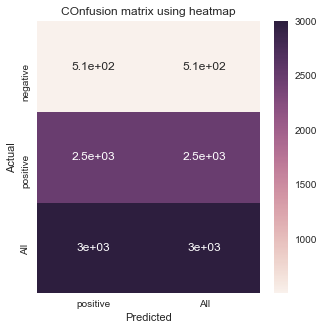


The optimal number of neighbors and misclassification error using brute  is 9 4
Predicted  positive   All
Actual                   
negative        507   507
positive       2493  2493
All            3000  3000


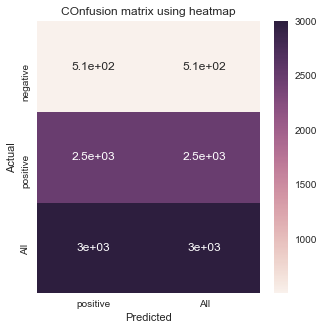

In [23]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')

#x = pd.DataFrame(sent_vectors)
#y = clean_data['Score']
#n=x.shape[0]
#n1=int(n*.3)
#X_test = x[0:n1]
#X_train= x[n1:n+1]
#y_test=y[0:n1]
#y_train=y[n1:n+1]
#print('train and test X y',X_train.shape,X_test.shape,y_train.shape,y_test.shape)




# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
  
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error usinf kd-tree is',optimal_k,MSE.index(min(MSE)))


# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
pred = knn_optimal.predict(X_test)
acctrain = accuracy_score(y_test, pred) * 100

bb=pd.DataFrame({'type':['avg W2V kd-tree'],'train_score':[acctrain],'test_score':[acc],'K':[optimal_k]})
aa=aa.append(bb)
#confusion matrix
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);
plt.figure(figsize=(5,5))
sns.heatmap(mat,annot=True)
plt.title("COnfusion matrix using heatmap")
plt.show()

# Use brute
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using brute  is',optimal_k,MSE.index(min(MSE)))  

# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
#print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))
pred = knn_optimal.predict(X_test)
acctrain = accuracy_score(y_test, pred) * 100

bb=pd.DataFrame({'type':['avg W2V brute'],'train_score':[acctrain],'test_score':[acc],'K':[optimal_k]})
aa=aa.append(bb)
#confusion matrix
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);
plt.figure(figsize=(5,5))
sns.heatmap(mat,annot=True)
plt.title("COnfusion matrix using heatmap")
plt.show()

  

# plot accuracy with k value

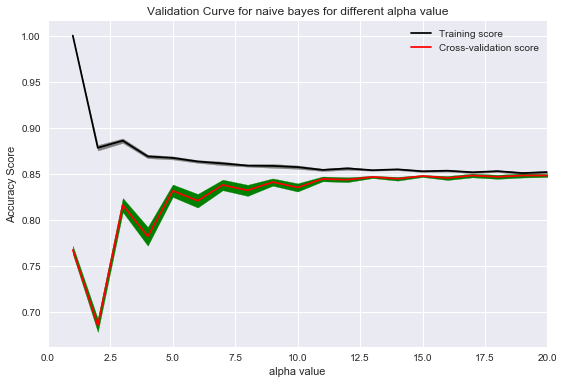

In [24]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
n_neighbors=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_range=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors",param_range=n_neighbors,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for naive bayes for different alpha value")
plt.xlabel("alpha value")
plt.ylabel("Accuracy Score")
plt.xlim(0,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Build model using avg tfidf w2v

(7000, 50) (3000, 50)
(7000,) (3000,)

The optimal number of neighbors and misclassification error using kd-tree is 9 4
Predicted  negative  positive   All
Actual                             
negative          6       501   507
positive          9      2484  2493
All              15      2985  3000


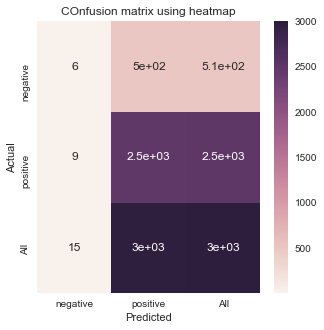


The optimal number of neighbors and misclassification error using brute  is 9 4
Predicted  negative  positive   All
Actual                             
negative          6       501   507
positive          9      2484  2493
All              15      2985  3000


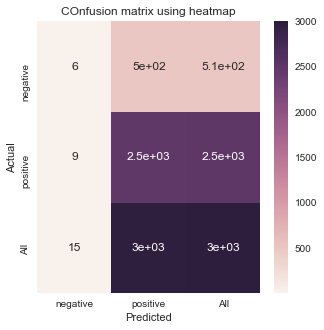

In [25]:
#ignore warning
import warnings
warnings.filterwarnings('ignore')


# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()
final_tf_idf=tf_idf_vect.fit_transform(X_train_raw)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
#tfidf_sent_vectors.

# do for test
final_tf_idf=tf_idf_vect.transform(X_test_raw)
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
#calculate avg tfidf score for each sentences 
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]#calculate w2v for each word
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]#get tfidf score of each word 
            sent_vec += (vec * tf_idf) # multiply vec with tfidf of each word and cumulative add of words in each sentence
            weight_sum += tf_idf # also add tfidf sums in each sentence
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1



#x=tfidf_sent_vectors
#y = clean_data['Score']
#n=len(x)
#n1=int(n*.3)
#X_test = x[0:n1]
#X_train= x[n1:n+1]
#y_test=y[0:n1]
#y_train=y[n1:n+1]
#print('X y train test ',len(X_train),len(X_test),y_train.shape,y_test.shape)
X_train = pd.DataFrame(tfidf_sent_vectors_train)
X_test = pd.DataFrame(tfidf_sent_vectors_test)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)




# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
  
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using kd-tree is',optimal_k,MSE.index(min(MSE)))


# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)
acc = accuracy_score(y_test, pred) * 100
#print('\nThe accuracy of the knn classifier using kd-tree for k = %d is %f%%' % (optimal_k, acc))
pred = knn_optimal.predict(X_test)
acctrain = accuracy_score(y_test, pred) * 100

bb=pd.DataFrame({'type':['avg tfidf W2V kdtree'],'train_score':[acctrain],'test_score':[acc],'K':[optimal_k]})
aa=aa.append(bb)
#confusion matrix
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);
plt.figure(figsize=(5,5))
sns.heatmap(mat,annot=True)
plt.title("COnfusion matrix using heatmap")
plt.show()

  
# Use brute
# Create 10 fold cross validation
myList = list(range(0,10))
neighbors = list(filter(lambda x: x % 2 != 0, myList))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors and misclassification error using brute  is',optimal_k,MSE.index(min(MSE)))  

# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
#print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))
pred = knn_optimal.predict(X_test)
acctrain = accuracy_score(y_test, pred) * 100

bb=pd.DataFrame({'type':['avg tfidf W2V brute'],'train_score':[acctrain],'test_score':[acc],'K':[optimal_k]})
aa=aa.append(bb)
#confusion matrix
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);
plt.figure(figsize=(5,5))
sns.heatmap(mat,annot=True)
plt.title("COnfusion matrix using heatmap")
plt.show()

  

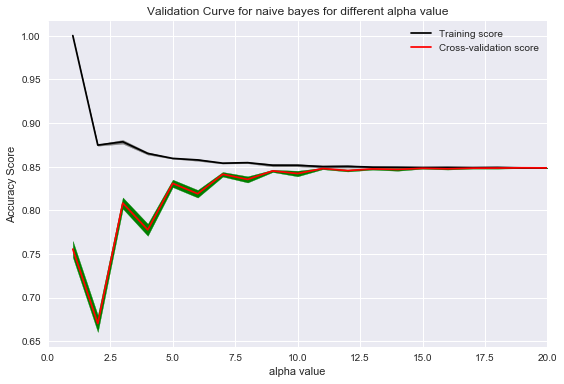

In [26]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import validation_curve
#create plot for training and test validation
# We cannot put 0 in parameter it will give error while validation_curve
n_neighbors=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_range=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors",param_range=n_neighbors,cv=5)
#print(train_scores,test_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve for naive bayes for different alpha value")
plt.xlabel("alpha value")
plt.ylabel("Accuracy Score")
plt.xlim(0,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Conclusion
The knn is very slow compare to other model

## Below are the steps followed
Only !=3 reviews are taken
Mark >3 as positive and <3 as negative. 1
Sort data as per product id in ascending order
Deduplication of entries for same profilename,userid, time, text and take first element 
Get stratified sampling of 10000 data
Clean html and punctuation
Convert to uppercase and word<3 are rejected
data sorted on time
Split the data in train and test to 70:30


BOW
BOW vec created using train data
test data is converted using above
For different value of k and cv=10 bet k is choosen for brute and kd-tree
accuracy matrix is saved in dataframe, cnfusion matrix is plot using seaborn. plot accuracy for different k

TFIDF
vec created using train data same applied to test text
rest are same as BOW

AVG W2V
gensim is used to create avg W2V for each sentence of train and test data. rest are same as above

Avg TFIDF W2V
tfidf is created from train data, that data and gensim is used to calculate
sent_vect avg tfidf w2v for train and test. rest are same



## The performance of each model below

In [27]:
aa

,K,test_score,train_score,type
0,9,83.166667,85.357143,BOW brute
0,9,83.166667,85.357143,BOW kdtree
0,7,84.233333,87.000000,TFIDF kd_tree
0,7,84.233333,84.233333,TFIDF brute
0,9,83.100000,83.100000,avg W2V kd-tree
0,9,83.100000,83.100000,avg W2V brute
0,9,83.000000,83.000000,avg tfidf W2V kdtree
0,9,83.000000,83.000000,avg tfidf W2V brute
